In [ ]:
# AUTO click
from pynput.mouse import Controller,Button
import time

mouse = Controller()

while True:
    mouse.click(Button.left,1)
    print('clicked')
    time.sleep(10)

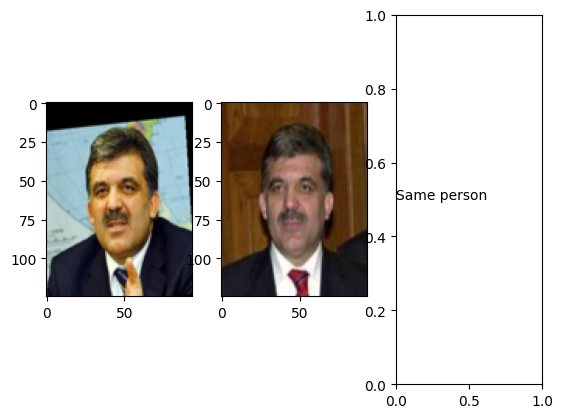

In [4]:
from sklearn.datasets import fetch_lfw_pairs
import matplotlib.pyplot as plt
lfw = fetch_lfw_pairs(subset = "test", color = True, resize = 1)

pairs = lfw.pairs
labels = lfw.target
target_names = lfw.target_names

actuals = []; predictions = []
for i in range(0, 1):
   pair = pairs[i]
   img1 = pair[0]
   img2 = pair[1]
 
   fig = plt.figure()
 
   ax1 = fig.add_subplot(1,3,1)
   plt.imshow(img1)
 
   ax2 = fig.add_subplot(1,3,2)
   plt.imshow(img2)
 
   ax3 = fig.add_subplot(1,3,3)
   plt.text(0, 0.50, target_names[labels[i]])
 
   plt.show()
